In [1]:
import random
from pathlib import Path
from math import sqrt, pi

import numpy as np
#from scipy.stats import ttest_rel, ttest_ind, wilcoxon
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
# Load in all csv result files & combine them to one pandas table
wells = ['B' + '{0:02d}'.format(x) for x in range(2,6)] + \
        ['C' + '{0:02d}'.format(x) for x in range(2,6)] + \
        ['D' + '{0:02d}'.format(x) for x in range(2,6)] + \
        ['E' + '{0:02d}'.format(x) for x in range(2,6)]

base_path_features = '/Users/Joel/shares/workShareJoel/20190505-WTC-PermeabilizationTest5/Nuclei_features/20190505-WTC-PermeabilizationTest5_p1_'
base_path_metadata = '/Users/Joel/shares/workShareJoel/20190505-WTC-PermeabilizationTest5/Nuclei_features/20190505-WTC-PermeabilizationTest5_p1_'
base_path_popcon = '/Users/Joel/shares/workShareJoel/20190505-WTC-PermeabilizationTest5/popcon_features/20190505-WTC-PermeabilizationTest5_p1_'

results = pd.DataFrame()

for well in wells:
    curr_features = pd.read_csv(base_path_features + well + '_Nuclei_feature-values.csv')
    curr_metadata = pd.read_csv(base_path_metadata + well + '_Nuclei_metadata.csv')
    curr_popcon = pd.read_csv(base_path_popcon + well + '_Nuclei_popcon.csv')
    curr_well_tmp = curr_features.merge(curr_metadata, on = ['mapobject_id'])
    curr_well = curr_well_tmp.merge(curr_popcon, on = ['mapobject_id'])
    results = pd.concat([results, curr_well])

# print(results.head())
print(results.columns.values)

['mapobject_id' 'Morphology_Local_Centroid_x'
 'Morphology_Local_Centroid_y' 'Morphology_Area' 'Morphology_Perimeter'
 'Morphology_Eccentricity' 'Morphology_Extent' 'Morphology_Convexity'
 'Morphology_Circularity' 'Morphology_Roundness' 'Morphology_Elongation'
 'Morphology_Equivalent_Diameter' 'Morphology_Major_Axis_Length'
 'Morphology_Minor_Axis_Length' 'Morphology_Maximum_Radius'
 'Morphology_Mean_Radius' 'Intensity_max_DAPI' 'Intensity_mean_DAPI'
 'Intensity_min_DAPI' 'Intensity_sum_DAPI' 'Intensity_std_DAPI'
 'Intensity_max_nanog' 'Intensity_mean_nanog' 'Intensity_min_nanog'
 'Intensity_sum_nanog' 'Intensity_std_nanog' 'plate_name' 'well_name'
 'well_pos_y' 'well_pos_x' 'tpoint' 'zplane' 'label' 'is_border' 'Mitotic'
 'Classification-327' 'Classification-328' 'Classification-329'
 'Missegmented' 'Classification-331' 'DAPI-dirt'
 'Morphology_Global_Centroid_x' 'Morphology_Global_Centroid_y'
 'Crowding_Nuclei' 'LCC_Nuclei' 'LocalDensity_Nuclei_100'
 'LocalDensity_Nuclei_200' 'LocalD

In [41]:
# Filter out cells that are thrown out by SVM
clean_dapi = (results['DAPI-dirt'] == 0)
correct_segment = (results['Missegmented'] == 0)
non_mitotic = (results['Mitotic'] == 0)
non_border_cells = (results['is_border'] == 0)

# Filter out cells that have very low DAPI signal. Mostly missegmented HEK cells
normal_dapi = (results['Intensity_sum_DAPI'] < 7000000) & (results['Intensity_sum_DAPI'] > 1500000)
# Filter out huge cells (missegmented cells)
normal_area = (results['Morphology_Area'] < 10000) & (results['Morphology_Area'] > 2000)

results_cleaned = results.loc[clean_dapi & correct_segment & non_mitotic & non_border_cells & normal_dapi & normal_area]
# results_cleaned = results.loc[normal_dapi & normal_area]
print('Filtered out {} cells, kept {} ({:.2f}%)'.format(results.shape[0] - results_cleaned.shape[0], results_cleaned.shape[0], results_cleaned.shape[0]/results.shape[0] *100))

results_cleaned['DAPI/nanog_sumIntensity'] = results_cleaned['Intensity_sum_DAPI'] / results_cleaned['Intensity_sum_nanog']

Filtered out 179756 cells, kept 485954 (73.00%)


In [4]:
# # Define well sub-selections
# hela = ['C' + '{0:02d}'.format(x) for x in range(3,11)] + \
#        ['D' + '{0:02d}'.format(x) for x in range(3,11)]
# hek = ['E' + '{0:02d}'.format(x) for x in range(3,11)] + \
#       ['F' + '{0:02d}'.format(x) for x in range(3,11)]

# hela_cells = (results_cleaned['well_name'].isin(hela))
# hek_cells = (results_cleaned['well_name'].isin(hek))

# hela_C_row = (results_cleaned['well_name'].isin(['C' + '{0:02d}'.format(x) for x in range(3,11)]))
# hek_E_row = (results_cleaned['well_name'].isin(['E' + '{0:02d}'.format(x) for x in range(3,11)]))

# hela_T1 = ['C' + '{0:02d}'.format(x) for x in range(3,9)]  #+ \
# #           ['D' + '{0:02d}'.format(x) for x in range(3,9)]
# hek_T1 = ['E' + '{0:02d}'.format(x) for x in range(3,9)] #+ \
# #          ['F' + '{0:02d}'.format(x) for x in range(3,9)]

# hela_T4 = ['C' + '{0:02d}'.format(x) for x in range(9,11)]
# hek_T4 = ['E' + '{0:02d}'.format(x) for x in range(9,11)]

# hela_cells_T1 = (results_cleaned['well_name'].isin(hela_T1))
# hek_cells_T1 = (results_cleaned['well_name'].isin(hek_T1))
# hela_cells_T4 = (results_cleaned['well_name'].isin(hela_T4))
# hek_cells_T4 = (results_cleaned['well_name'].isin(hek_T4))

# # Create a combined mRNA spot count column for total count & count in Pbodies (col 3-8 => T1, col 9 & 10 => T4)
# results_cleaned = results_cleaned.assign(mRNA_Pbody_Count = results_cleaned['mRNA_Pbody_T1_Count'])
# results_cleaned.loc[(hela_cells_T4 | hek_cells_T4),'mRNA_Pbody_Count'] = results_cleaned['mRNA_Pbody_T4_Count'][hela_cells_T4 | hek_cells_T4]
# results_cleaned = results_cleaned.assign(mRNA_Count = results_cleaned['mRNA_T1_Count_bDNA-FISH'])
# results_cleaned.loc[(hela_cells_T4 | hek_cells_T4),'mRNA_Count'] = results_cleaned['mRNA_T4_Count_bDNA-FISH'][hela_cells_T4 | hek_cells_T4]

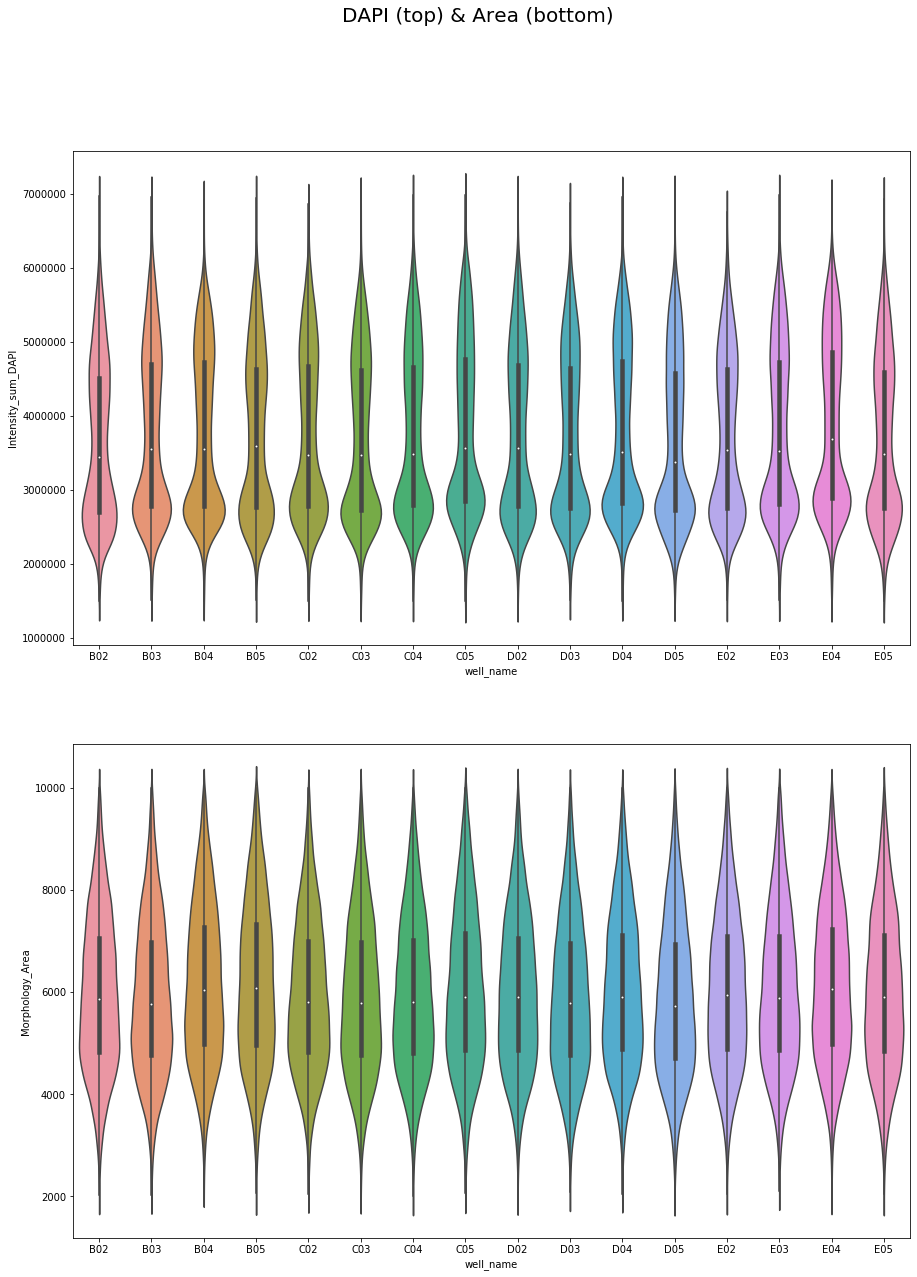

In [42]:
# Make some quality control plots
# DAPI violin plots
fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
fig1.suptitle('DAPI (top) & Area (bottom)', fontsize = 20)
sns.violinplot(x = 'well_name', y = 'Intensity_sum_DAPI', data = results_cleaned, ax=ax1[0])
sns.violinplot(x = 'well_name', y = 'Morphology_Area', data = results_cleaned, ax=ax1[1])

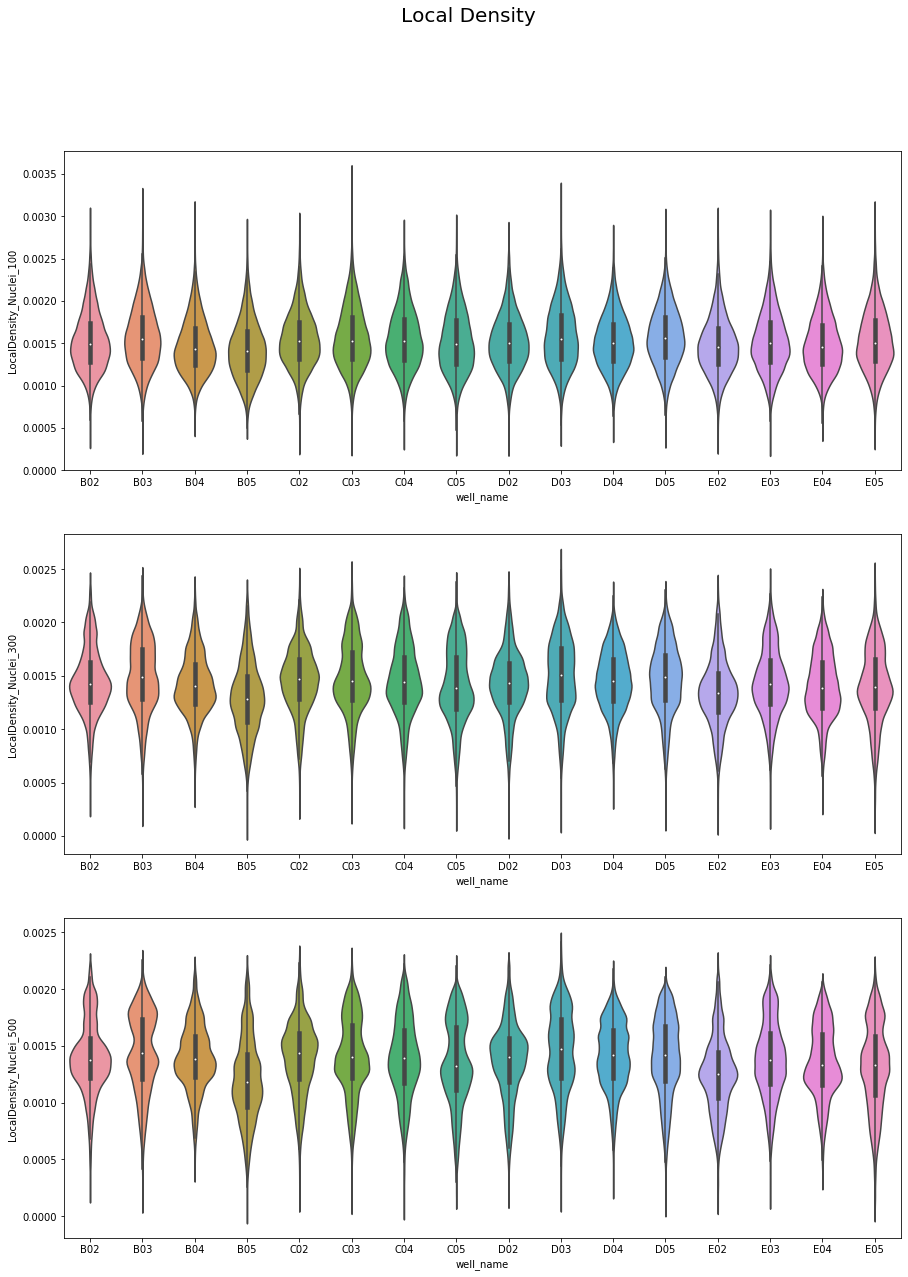

In [123]:
# Plot local density measurements
fig1, ax1 = plt.subplots(3, 1, figsize=(15, 20))
fig1.suptitle('Local Density', fontsize = 20)
sns.violinplot(x = 'well_name', y = 'LocalDensity_Nuclei_100', data = results_cleaned, ax=ax1[0])
sns.violinplot(x = 'well_name', y = 'LocalDensity_Nuclei_300', data = results_cleaned, ax=ax1[1])
sns.violinplot(x = 'well_name', y = 'LocalDensity_Nuclei_500', data = results_cleaned, ax=ax1[2])

0.1366030800696677
0.20921605042739236
0.10388311647366699
0.2601928218150626
0.20380889862385385
0.20163097747858627
0.21433978869323864
0.23115329799401324
0.14935220022601003
0.1313155693243598
0.14012979859218827
0.16847847259633583
0.16205954135313955
0.15882245340014342
0.16292429799343555
0.18295784001295404


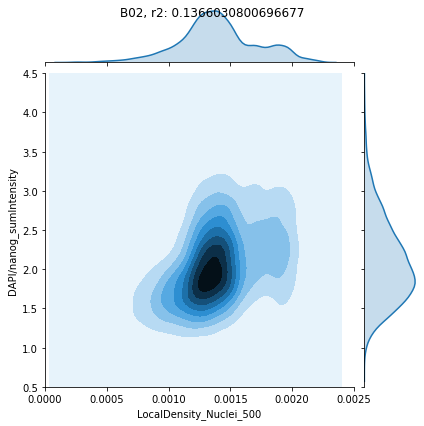

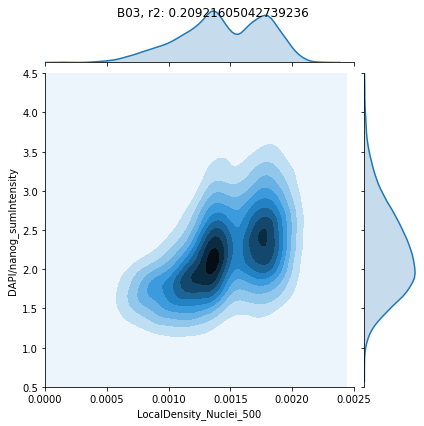

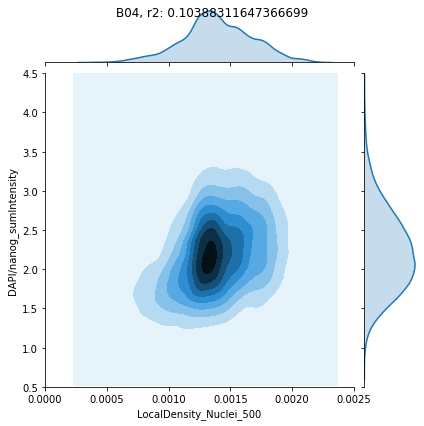

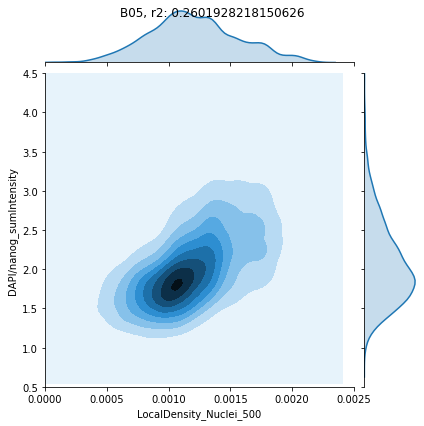

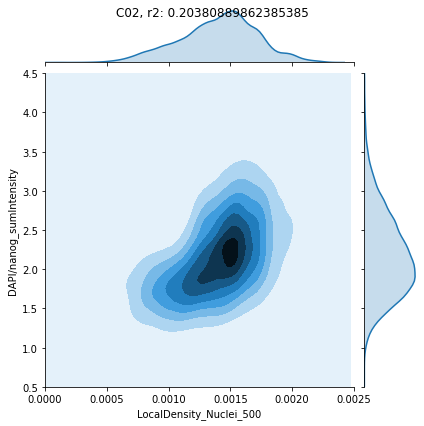

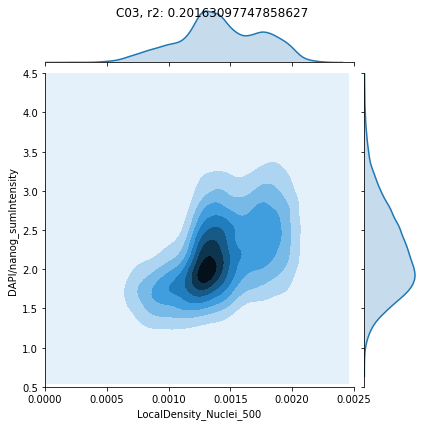

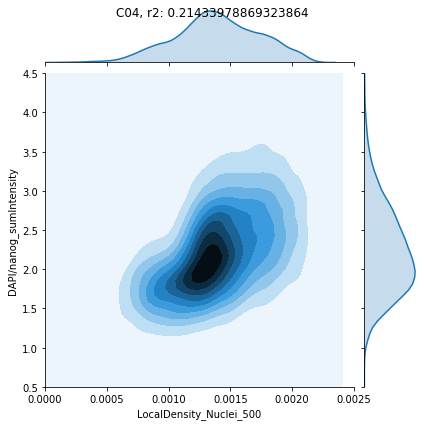

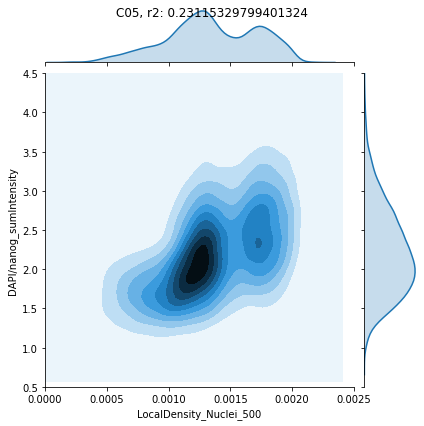

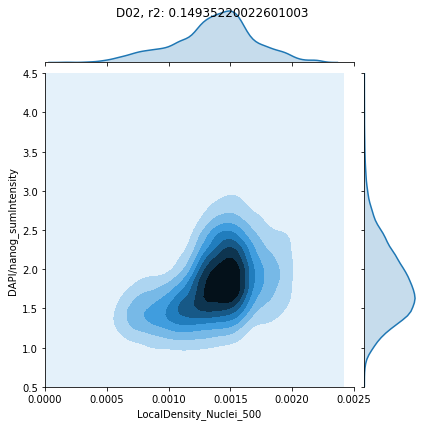

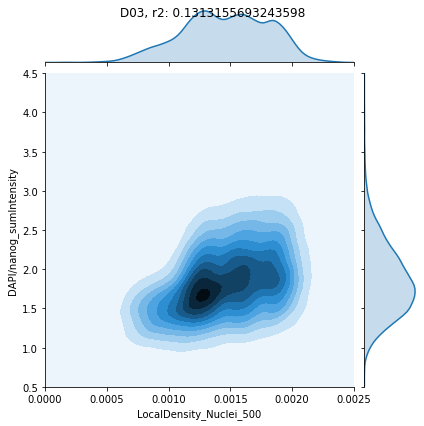

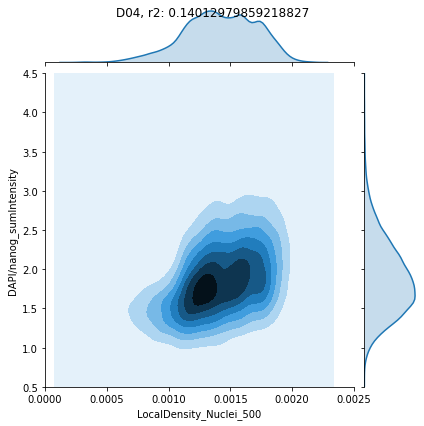

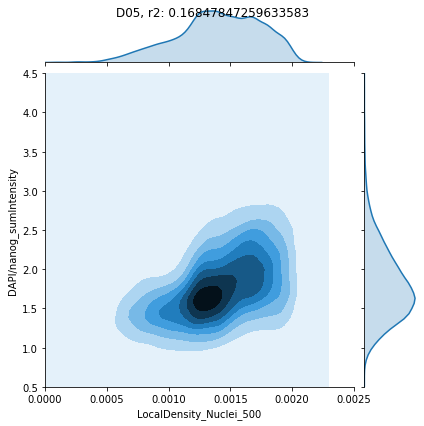

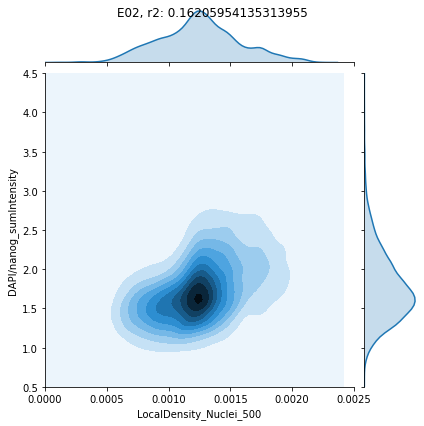

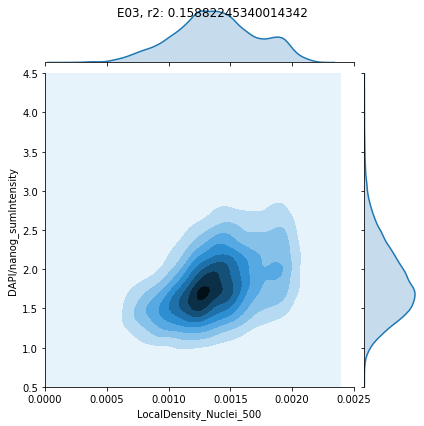

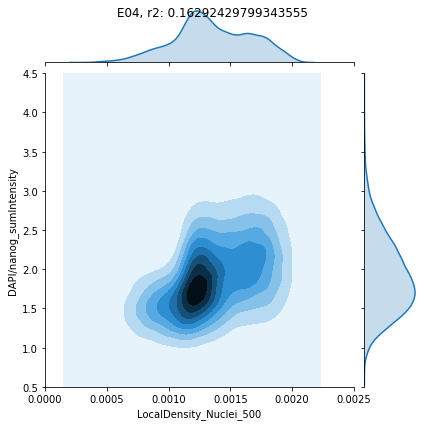

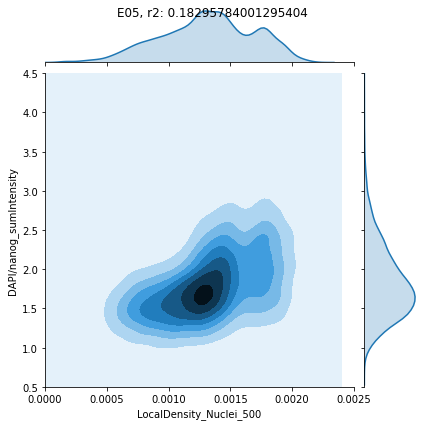

In [122]:
# Plot relationship DAPI/nanog (vs. density)
import scipy
# well_name = 'B04'
for well_name in wells:
    curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]

    # fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
    # fig1.suptitle('DAPI/nanog Intensity Ratio', fontsize = 20)
    # sns.violinplot(x = 'well_name', y = 'DAPI/nanog_sumIntensity', data = results_cleaned, ax=ax1[0])

    # g = sns.jointplot(x = 'LocalDensity_Nuclei_500', y = 'DAPI/nanog_sumIntensity', data = curr_well, s=5, xlim=(0, 0.0025), ylim = (0.5, 4.5)) # 
    g = sns.jointplot(x = 'LocalDensity_Nuclei_500', y = 'DAPI/nanog_sumIntensity', data = curr_well, s=5, xlim=(0, 0.0025), ylim = (0.5, 4.5), kind ='kde')

    # Calculate correlation between Density & DAPI/nanog
    density = np.array(curr_well['LocalDensity_Nuclei_500'])
    intensity_ratio = np.array(curr_well['DAPI/nanog_sumIntensity'])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(density, intensity_ratio)
    print(r_value*r_value)


    g.fig.suptitle(well_name + ', r2: ' + str(r_value*r_value))

    g.savefig(well_name + '_DensityVsStainingBias.png')


In [116]:
# Calculate correlation between Density & DAPI/nanog
import scipy
well_name = 'B02'
curr_well = results_cleaned.loc[(results_cleaned['well_name'] == well_name)]

density = np.array(curr_well['LocalDensity_Nuclei_500'])
intensity_ratio = np.array(curr_well['DAPI/nanog_sumIntensity'])
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(density, intensity_ratio)
print(r_value*r_value)



0.1366030800696677


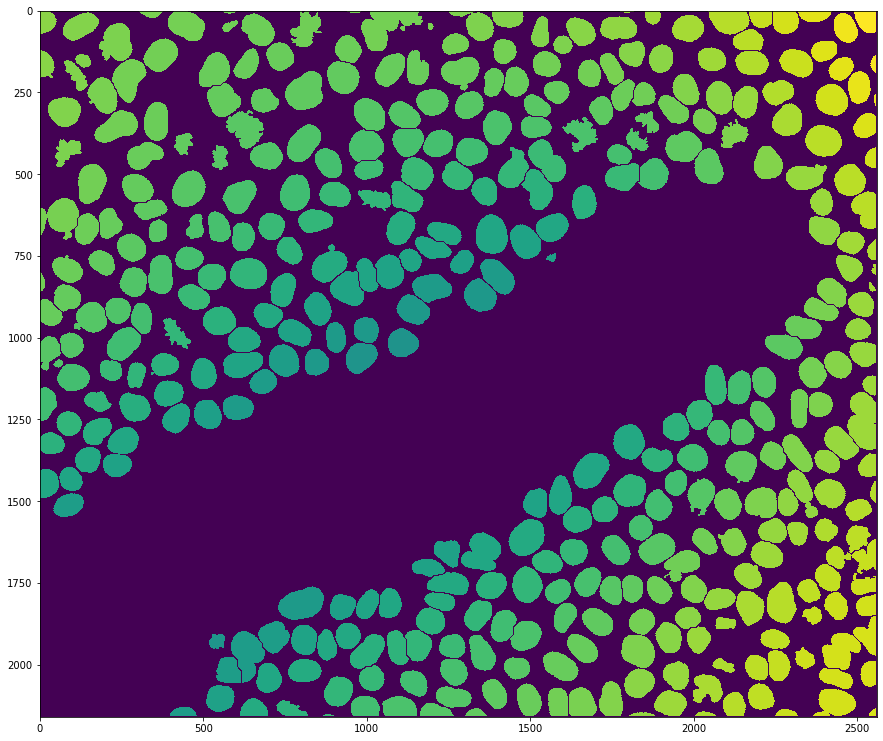

In [4]:
# Local density mapped back on the images
img_width = 2560
img_height = 2160

density_img = np.zeros((img_width, img_height))

# Define site of interest
well_name = 'B02'
well_pos_y = 2
well_pos_x = 5
current_site_bool = (results['well_name'] == well_name) & (results['well_pos_y'] == well_pos_y)  & (results['well_pos_x'] == well_pos_x)

current_site = results.loc[current_site_bool]

# Get the segmentation mask from TissueMaps
import tmclient
host="172.23.47.46"
port = 80
experimentName="20190505-WTC-PermeabilizationTest5"
username="joel"
password="123456"
mapobject="Cells"
client = tmclient.TmClient(host, port, username, password, experimentName)

plateDownload = client.get_plates()
plate_name = plateDownload[0]['name']

segmentation_image = client.download_segmentation_image('Nuclei', plate_name, well_name, well_pos_y, well_pos_x)
# plt.figure(figsize=(15,20))
# imgplot = plt.imshow(segmentation_image)

img_width = 2560
img_height = 2160

density_img = np.zeros((img_height, img_width))

# Loop through all labels
labels = current_site['label']

for label in labels:
    current_cell = current_site.loc[current_site['label'] == label]
    density_img[segmentation_image == label] = current_cell['LocalDensity_Nuclei_500']

plt.figure(figsize=(15,20))
imgplot = plt.imshow(density_img)


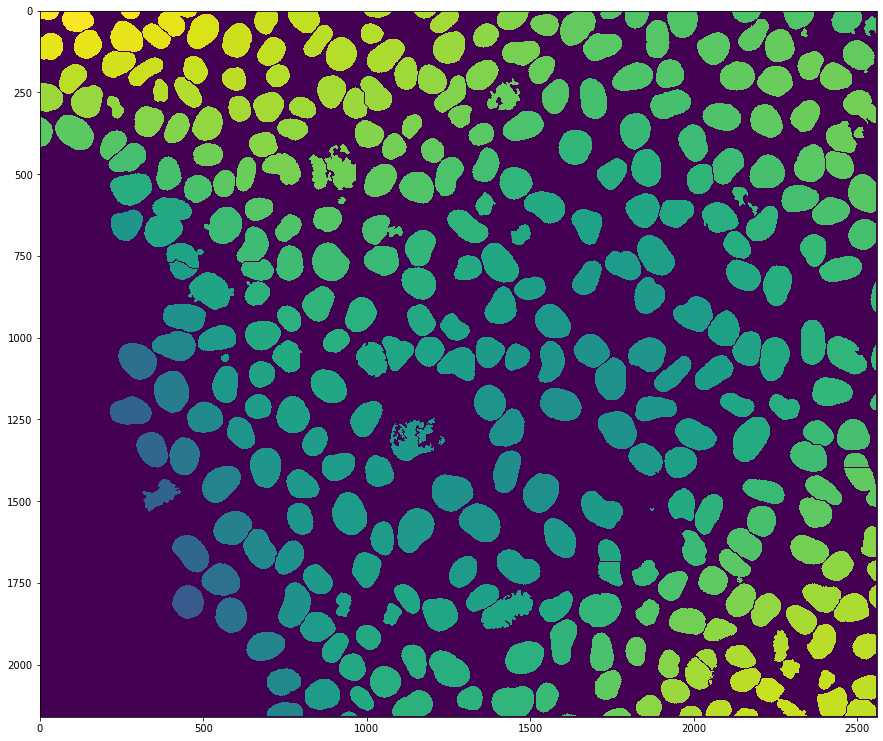

In [75]:
img_width = 2560
img_height = 2160

density_img = np.zeros((img_height, img_width))

# Loop through all labels
labels = current_site['label']

for label in labels:
    current_cell = current_site.loc[current_site['label'] == label]
    density_img[segmentation_image == label] = current_cell['LocalDensity_Nuclei_500']

plt.figure(figsize=(15,20))
imgplot = plt.imshow(density_img)


In [31]:
# Calculate average spot counts per well 
# print(results_cleaned.groupby('well_name')['mRNA_Count'].median())
# print(results_cleaned.groupby('well_name')['mRNA_Pbody_Count'].mean())

In [27]:
# Look at percentage of transcripts in P-bodies
# results_cleaned = results_cleaned.assign(percentage_pbody_2 = 0)
# cells_with_pbodies = results_cleaned['mRNA_Count'] >= 1
# results_cleaned.loc[cells_with_pbodies,'percentage_pbody'] = results_cleaned['mRNA_Pbody_Count'][cells_with_pbodies]/results_cleaned['mRNA_Count'][cells_with_pbodies]
# print(results_cleaned['percentage_pbody'].describe())


In [28]:
# fig1, ax1 = plt.subplots(2, 1, figsize=(15, 20))
# fig1.suptitle('mRNA Spot counts', fontsize = 20)
# g = sns.violinplot(x = 'well_name', y = 'percentage_pbody', data = results_cleaned.loc[hela_C_row], ax=ax1[0])
# g.set(xticklabels=['HPRT', 'Lamp1', 'CCND1', 'HIF1A', 'dapB', 'no probe', 'SPEN', 'no probe'])
# h = sns.violinplot(x = 'well_name', y = 'percentage_pbody', data = results_cleaned.loc[hek_E_row], ax=ax1[1])
# h.set(xticklabels=['HPRT', 'Lamp1', 'CCND1', 'HIF1A', 'dapB', 'no probe', 'SPEN', 'no probe'])


In [29]:
# Plot percentage P-bodies vs cellular features (area, #Pbodies total, DNA content, protein content)
# fig1, ax1 = plt.subplots(2, 2, figsize=(15, 15))
# fig1.suptitle('Percentage Pbodies vs. cell Features', fontsize = 20)
# SPEN_hek = results_cleaned['well_name'] == 'E09'
# sns.jointplot(x = 'Nuclei_Intensity_sum_DAPI', y = 'percentage_pbody', data = results_cleaned.loc[SPEN_hek,], s=10)
# sns.jointplot(x = 'Pbodies_Count', y = 'percentage_pbody', data = results_cleaned.loc[SPEN_hek,],s=10)
# sns.jointplot(x = 'Morphology_Area', y = 'percentage_pbody', data = results_cleaned.loc[SPEN_hek,],s=10)
# sns.jointplot(x = 'Intensity_mean_Succs', y = 'percentage_pbody', data = results_cleaned.loc[SPEN_hek,],s=10)

# CCND1_hela = results_cleaned['well_name'] == 'C05'
# g = sns.jointplot(x = 'Nuclei_Intensity_sum_DAPI', y = 'percentage_pbody', data = results_cleaned.loc[CCND1_hela,], s=10)
# sns.jointplot(x = 'Pbodies_Count', y = 'percentage_pbody', data = results_cleaned.loc[CCND1_hela,],s=10)
# sns.jointplot(x = 'Morphology_Area', y = 'percentage_pbody', data = results_cleaned.loc[CCND1_hela,],s=10)
# sns.jointplot(x = 'Intensity_mean_Succs', y = 'percentage_pbody', data = results_cleaned.loc[CCND1_hela,],s=10)

# lamp1_hela = results_cleaned['well_name'] == 'C04'
# g = sns.jointplot(x = 'Nuclei_Intensity_sum_DAPI', y = 'percentage_pbody', data = results_cleaned.loc[lamp1_hela,], s=10)
# sns.jointplot(x = 'Pbodies_Count', y = 'percentage_pbody', data = results_cleaned.loc[lamp1_hela,],s=10)
# sns.jointplot(x = 'Morphology_Area', y = 'percentage_pbody', data = results_cleaned.loc[lamp1_hela,],s=10)
# sns.jointplot(x = 'Intensity_mean_Succs', y = 'percentage_pbody', data = results_cleaned.loc[lamp1_hela,],s=10)


In [20]:
# Save dataframe as csv
# results_cleaned.to_csv('20181203-bDNA-FISH8-results-cleaned_improved.csv')

Load data directly from TissueMaps for single wells

In [30]:
# import tmclient
# host="172.23.47.46"
# port = 80
# experimentName="20181203-bDNA-FISH-8"
# username="joel"
# password="123456"
# mapobject="Cells"
# client = tmclient.TmClient(host, port, username, password, experimentName)

# plateDownload = client.get_plates()
# plate_name = plateDownload[0]['name']

# wells = ['C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'E03', 'E08']
# for well in wells:
#     print(well)
#     site_y = 0
#     for site_x in range(1,3):
#         feature_values = client.download_feature_values(mapobject, plate_name, well, site_y, site_x)
#         print(feature_values['mRNA_T1_Count_bDNA-FISH'].mean())
# #         print(feature_values['mRNA_Pbody_T1_Count'].mean())

# wells = ['C09', 'C10']
# for well in wells:
#     print(well)
#     site_y = 0
#     for site_x in range(1,3):
#         feature_values = client.download_feature_values(mapobject, plate_name, well, site_y, site_x)
#         print(feature_values['mRNA_T4_Count_bDNA-FISH'].mean()) 